In [1]:
import numpy as np
# import random
import math
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import time
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.utils import shuffle
import cv2 as cv
from sklearn.utils.extmath import row_norms
from sklearn.utils.extmath import row_norms, squared_norm, stable_cumsum
import scipy.sparse as sp
from sklearn.metrics.pairwise import euclidean_distances
np.random.seed(5)

In [2]:
# intialize random member ship
def initializeMembershipMatrix(n,cluster):
    membership_mat = list()
    for i in range(n.shape[0]):
        random_num_list = [ np.random.rand() for i in range(cluster)]
        summation = sum(random_num_list) 
        temp_list = [x/summation for x in random_num_list]
        membership_mat.append(temp_list) 
    return np.asarray(membership_mat) 

In [3]:
def updateMembershipValue3_2(v,val):
    distances = cdist(val, v,metric='euclidean')
    return distances

In [4]:
def CalculateWeightValues(cluster_center,val,q):        
    membership=[]    
    distances = cdist(val, cluster_center,metric='euclidean')[:,q]  
    sumdistance=np.sum(distances)
    
    if(sumdistance==0): 
#         print('==****=== sum distance ==0', val, val.shape)
        print('==****=== sum distance ==0', val.shape)

        sumdistance=val.shape[0]*distances[0]
        
    membership= distances/sumdistance    
    return membership

In [5]:
def CalculateWeightValuesByIndex(cluster_center,val,q,index):        
    distances = cdist(val, v,metric='euclidean')[:,q]  
    sumdistance=np.sum(distances)
    membership= distances[index]/sumdistance        
    return membership

In [6]:
def _k_init(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):
    """Init n_clusters seeds according to k-means++
    Parameters
    ----------
    X : array or sparse matrix, shape (n_samples, n_features)
        The data to pick seeds for. To avoid memory copy, the input data
        should be double precision (dtype=np.float64).
    n_clusters : integer
        The number of seeds to choose
    x_squared_norms : array, shape (n_samples,)
        Squared Euclidean norm of each data point.
    random_state : int, RandomState instance
        The generator used to initialize the centers. Use an int to make the
        randomness deterministic.
        See :term:`Glossary <random_state>`.
    n_local_trials : integer, optional
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)); this is the default.
    Notes
    -----
    Selects initial cluster centers for k-mean clustering in a smart way
    to speed up convergence. see: Arthur, D. and Vassilvitskii, S.
    "k-means++: the advantages of careful seeding". ACM-SIAM symposium
    on Discrete algorithms. 2007
    Version ported from http://www.stanford.edu/~darthur/kMeansppTest.zip,
    which is the implementation used in the aforementioned paper.
    """
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)

        # Compute distances to center candidates
        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        # Decide which candidate is the best
        best_candidate = None
        best_pot = None
        best_dist_sq = None
        for trial in range(n_local_trials):
            # Compute potential when including center candidate
            new_dist_sq = np.minimum(closest_dist_sq,
                                     distance_to_candidates[trial])
            new_pot = new_dist_sq.sum()

            # Store result if it is the best local trial so far
            if (best_candidate is None) or (new_pot < best_pot):
                best_candidate = candidate_ids[trial]
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]
        current_pot = best_pot
        closest_dist_sq = best_dist_sq

    return centers

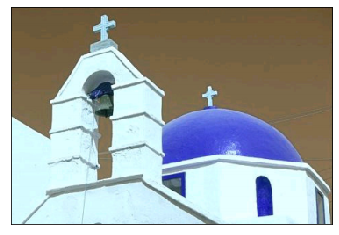

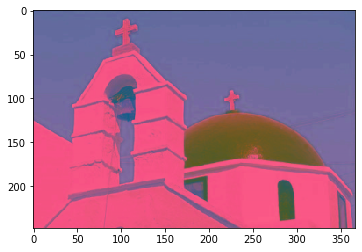

In [16]:
img=cv.imread('1.png')
# img=cv.cvtColor(img,cv.COLOR_BGR2RGB)

plt.imshow(img) 
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

pic=cv.cvtColor(img,cv.COLOR_RGB2LUV)
plt.imshow(pic) 

In [17]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
# pic_n = pic.reshape(pic.shape[0]*pic.shape[1], 1)
pic_n.shape
x=pic_n

In [18]:
def generateRandomCenters(c,x):
    centers=[]
    _min= (np.min(x))
    _max= (np.max(x))
    t= np.mean(x,axis=0)    
    for i in range(c):
        centers.append( t + 0.01*i)   
    return np.asarray(centers) 

generateRandomCenters(2,x)

array([[160.63055946,  95.4522941 , 136.25999824],
       [160.64055946,  95.4622941 , 136.26999824]])

In [37]:
import time 
timearray=[]
segementedImg=[]

clusterssize=[2,3,4,5,6,7,8,9,10]
error=[]

In [38]:
# _k_init(x,cluster, row_norms(x, squared=True), np.random.RandomState(seed=0))

In [ ]:
for cluster in clusterssize:
    
    #initialize centers
    if(i==2):
        c=_k_init(x,cluster, row_norms(x, squared=True), np.random.RandomState(seed=0))
        v= c
    else:
        c=generateRandomCenters(cluster,x)
        v= c
        
    # update membership
    w=updateMembershipValue3_2(v,x)    
    ny=np.argmin(w,axis=1)
    
    start=time.time()           
    
    for t in range(50):
#         print('\t\t',t)
        
        for q in range(cluster): 

            val=x[ny == q,:] 

            if(val.shape[0]!=0):

                weight=CalculateWeightValues(v,val,q) 

                temp=0    
                for i in range(val.shape[0]):                
                    temp += weight[i]*(val[i]- v[q])
                v[q]= v[q]+temp    

        w=updateMembershipValue3_2(v,x)  
        ny=np.argmin(w,axis=1)
    
    timearray.append(time.time()-start)    
    
    label=ny
    pic2show = v[label]
    
    cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], 3) 
    error.append(np.linalg.norm(pic-cluster_pic))
    
    print(v)
    print(cluster)

[[110.67294161 100.30098774 125.09824029]
 [233.23987797  84.8709342  129.35572823]]
2
[[113.37838975 101.74948051 150.23953992]
 [109.66214497  89.09785561  54.45708312]
 [232.93003448  84.87511052 129.34742844]]
3
[[106.49281282 103.69443666 153.47407711]
 [104.99924437  89.15913232  51.66107812]
 [162.90071085  88.19865766 120.12935804]
 [239.80141991  84.64409242 129.96661152]]
4
[[105.42273596 104.8427426  155.47755768]
 [104.85062567  89.16385316  51.4123738 ]
 [131.67842075  90.06708387 128.87208702]
 [176.72939093  87.49763009 115.65126648]
 [240.74573904  84.62486371 129.98286043]]
5
[[ 57.77683634  90.79143875  97.54597349]
 [113.90338754  88.86843883  46.11862363]
 [133.17652792  90.0155572  129.14119658]
 [108.81099791 105.88814535 157.66769515]
 [178.39371146  87.4889563  117.20597722]
 [240.87759235  84.62117722 129.97770971]]
6


In [ ]:
plt.xlabel('Number of Clusters')
plt.ylabel('Error')
plt.plot(clusterssize,error)

In [ ]:
plt.xlabel('Number of Clusters')
plt.ylabel('Time [Sec]')

plt.plot(np.arange(2,11,1),timearray)
np.savetxt("POCS_timearray.csv", timearray, delimiter=",")
np.savetxt("POCS_segementedImg.csv", segementedImg, delimiter=",")

In [ ]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1],3)
plt.imshow(cluster_pic/255,cmap='gray')

In [ ]:
print(np.unique(ny))
print(np.unique(ny).shape)